In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 2

#Build the encoder
encoder_inputs = keras.Input(shape=(88, 1))
x = layers.Conv1D(8, 3, activation='relu', padding='same', dilation_rate=2)(encoder_inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same', dilation_rate=2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
encoder = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(88 * 8)(x)
x = layers.Reshape((88, 8))(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x)
decoded = layers.Cropping1D(cropping=(0, 264))(decoded)
decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum((data - reconstruction) ** 2, axis=(1, 2))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 0.35 * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    def test_step(self, data):
        x = data

        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstructed_x = self.decoder(z, training=False)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum((x - reconstructed_x) ** 2, axis=(1, 2))
        )

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + 0.35 * kl_loss

        results = {m.name: m.result() for m in self.metrics}
        results["reconstruction_loss"] = reconstruction_loss
        results["kl_loss"] = kl_loss
        results["total_loss"] = total_loss
        return results



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 88, 1)]      0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 88, 8)        32          ['input_5[0][0]']                
                                                                                                  
 max_pooling1d_4 (MaxPooling1D)  (None, 44, 8)       0           ['conv1d_10[0][0]']              
                                                                                                  
 conv1d_11 (Conv1D)             (None, 44, 16)       400         ['max_pooling1d_4[0][0]']        
                                                                                            

In [20]:
from sklearn.preprocessing import MinMaxScaler

features = pd.read_csv('features.csv')
labels = pd.read_csv('labels.csv')
(x_train, x_test, y_train, y_test) = train_test_split(
                                    features, labels, test_size=0.2, random_state=42)

x_train_seq = x_train.values[:, 0]
x_test_seq = x_test.values[:, 0]

x_train_features = x_train.values[:, 1:]
x_test_features = x_test.values[:, 1:]

scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train_features)
x_test = scaler.transform(x_test_features)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [21]:
learn_rate = [0.001, 0.005, 0.008, 0.01]
batch_size = [32, 64, 128, 256]

param_grid = dict(learn_rate=learn_rate, batch_size=batch_size)

best_score = None
best_params = {}

for lr in learn_rate:
    for bs in batch_size:
        print("Learning rate: ", lr)
        print("Batch size: ", bs)
        
        vae = VAE(encoder, decoder)
        vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))
        
        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
        early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1, restore_best_weights=True)
        
        vae.fit(x_train, batch_size=bs, epochs=30, validation_split = 0.2, 
                callbacks=[reduce_lr, early_stop])

        score = vae.evaluate(x_test)
        print(score)

        if best_score is None or score < best_score:
            best_score = score
            best_params = {'learn_rate': lr, 'batch_size': bs}

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

lr = best_params['learn_rate']
bs = best_params['batch_size']

Learning rate:  0.001
Batch size:  32
Epoch 1/30
210/210 [==============================] - 4s 7ms/step - loss: 1.3889 - reconstruction_loss: 1.1776 - kl_loss: 0.0117 - val_total_loss: 1.0776 - val_reconstruction_loss: 1.0721 - val_kl_loss: 0.0156 - lr: 0.0010
Epoch 2/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9841 - reconstruction_loss: 0.9739 - kl_loss: 0.0140 - val_total_loss: 1.0539 - val_reconstruction_loss: 1.0466 - val_kl_loss: 0.0207 - lr: 0.0010
Epoch 3/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9698 - reconstruction_loss: 0.9640 - kl_loss: 0.0202 - val_total_loss: 0.9947 - val_reconstruction_loss: 0.9828 - val_kl_loss: 0.0340 - lr: 0.0010
Epoch 4/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9663 - reconstruction_loss: 0.9428 - kl_loss: 0.0425 - val_total_loss: 1.0446 - val_reconstruction_loss: 1.0250 - val_kl_loss: 0.0560 - lr: 0.0010
Epoch 5/30
210/210 [==============================] - 1s 6ms/step - lo

105/105 [==============================] - 1s 9ms/step - loss: 0.9025 - reconstruction_loss: 0.7993 - kl_loss: 0.3063 - val_total_loss: 0.7884 - val_reconstruction_loss: 0.6378 - val_kl_loss: 0.4303 - lr: 0.0010
Epoch 7/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9150 - reconstruction_loss: 0.8000 - kl_loss: 0.3083 - val_total_loss: 0.7786 - val_reconstruction_loss: 0.6379 - val_kl_loss: 0.4018 - lr: 0.0010
Epoch 8/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9166 - reconstruction_loss: 0.8066 - kl_loss: 0.3054 - val_total_loss: 0.9707 - val_reconstruction_loss: 0.8270 - val_kl_loss: 0.4106 - lr: 0.0010
Epoch 9/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9006 - reconstruction_loss: 0.7985 - kl_loss: 0.2962 - val_total_loss: 0.8033 - val_reconstruction_loss: 0.6785 - val_kl_loss: 0.3567 - lr: 0.0010
Epoch 10/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9088 - reconstruction_loss: 0.8031 - kl_lo

Epoch 11/30
53/53 [==============================] - 1s 14ms/step - loss: 0.9055 - reconstruction_loss: 0.7946 - kl_loss: 0.3152 - val_total_loss: 0.8136 - val_reconstruction_loss: 0.6708 - val_kl_loss: 0.4080 - lr: 0.0010
Epoch 12/30
49/53 [==========================>...] - ETA: 0s - loss: 0.9080 - reconstruction_loss: 0.7923 - kl_loss: 0.3263
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
53/53 [==============================] - 1s 14ms/step - loss: 0.9080 - reconstruction_loss: 0.7940 - kl_loss: 0.3278 - val_total_loss: 0.9825 - val_reconstruction_loss: 0.8427 - val_kl_loss: 0.3995 - lr: 0.0010
Epoch 13/30
53/53 [==============================] - 1s 15ms/step - loss: 0.8983 - reconstruction_loss: 0.7902 - kl_loss: 0.3147 - val_total_loss: 0.8603 - val_reconstruction_loss: 0.7209 - val_kl_loss: 0.3982 - lr: 5.0000e-04
Epoch 14/30
53/53 [==============================] - 1s 16ms/step - loss: 0.8936 - reconstruction_loss: 0.7919 - kl_loss: 0.3162 - val_tot

Epoch 16/30
27/27 [==============================] - 1s 26ms/step - loss: 0.8963 - reconstruction_loss: 0.7890 - kl_loss: 0.3139 - val_total_loss: 0.9353 - val_reconstruction_loss: 0.7917 - val_kl_loss: 0.4101 - lr: 0.0010
Epoch 17/30
27/27 [==============================] - 1s 25ms/step - loss: 0.8941 - reconstruction_loss: 0.7873 - kl_loss: 0.3176 - val_total_loss: 0.9148 - val_reconstruction_loss: 0.7794 - val_kl_loss: 0.3870 - lr: 0.0010
Epoch 18/30
27/27 [==============================] - 1s 25ms/step - loss: 0.9083 - reconstruction_loss: 0.7898 - kl_loss: 0.3199 - val_total_loss: 0.9105 - val_reconstruction_loss: 0.7883 - val_kl_loss: 0.3490 - lr: 0.0010
Epoch 19/30
24/27 [=========================>....] - ETA: 0s - loss: 0.9080 - reconstruction_loss: 0.7941 - kl_loss: 0.3120
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
27/27 [==============================] - 1s 25ms/step - loss: 0.9077 - reconstruction_loss: 0.8002 - kl_loss: 0.3130 - val_total_l

Epoch 21/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9191 - reconstruction_loss: 0.8166 - kl_loss: 0.2712 - val_total_loss: 0.8998 - val_reconstruction_loss: 0.7921 - val_kl_loss: 0.3077 - lr: 0.0050
Epoch 22/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9092 - reconstruction_loss: 0.8109 - kl_loss: 0.3013 - val_total_loss: 0.8745 - val_reconstruction_loss: 0.7566 - val_kl_loss: 0.3367 - lr: 0.0050
Epoch 23/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9226 - reconstruction_loss: 0.8171 - kl_loss: 0.2778 - val_total_loss: 0.9361 - val_reconstruction_loss: 0.8202 - val_kl_loss: 0.3313 - lr: 0.0050
Epoch 24/30
210/210 [==============================] - 1s 7ms/step - loss: 0.9112 - reconstruction_loss: 0.8140 - kl_loss: 0.2961 - val_total_loss: 0.7703 - val_reconstruction_loss: 0.6431 - val_kl_loss: 0.3634 - lr: 0.0050
Epoch 25/30
201/210 [===========================>..] - ETA: 0s - loss: 0.9153 - reconstruction_loss: 0.8

Epoch 25/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9021 - reconstruction_loss: 0.7928 - kl_loss: 0.3188 - val_total_loss: 0.9540 - val_reconstruction_loss: 0.7968 - val_kl_loss: 0.4491 - lr: 0.0012
Epoch 26/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8912 - reconstruction_loss: 0.7860 - kl_loss: 0.3236 - val_total_loss: 0.9327 - val_reconstruction_loss: 0.7846 - val_kl_loss: 0.4232 - lr: 0.0012
Epoch 27/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9095 - reconstruction_loss: 0.7865 - kl_loss: 0.3178 - val_total_loss: 0.9271 - val_reconstruction_loss: 0.7827 - val_kl_loss: 0.4126 - lr: 0.0012
Epoch 28/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9008 - reconstruction_loss: 0.7884 - kl_loss: 0.3199 - val_total_loss: 0.8157 - val_reconstruction_loss: 0.6666 - val_kl_loss: 0.4259 - lr: 0.0012
Epoch 29/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8982 - reconstruction_loss:

Epoch 30/30
66/66 [==============================] - 0s 2ms/step - total_loss: 0.7949 - reconstruction_loss: 0.6701 - kl_loss: 0.3566
[0.7949203848838806, 0.6701186299324036, 0.35657641291618347]
Learning rate:  0.005
Batch size:  256
Epoch 1/30
27/27 [==============================] - 3s 34ms/step - loss: 0.9176 - reconstruction_loss: 0.8098 - kl_loss: 0.3121 - val_total_loss: 0.9194 - val_reconstruction_loss: 0.7745 - val_kl_loss: 0.4141 - lr: 0.0050
Epoch 2/30
27/27 [==============================] - 1s 26ms/step - loss: 0.9020 - reconstruction_loss: 0.7851 - kl_loss: 0.3279 - val_total_loss: 0.9502 - val_reconstruction_loss: 0.8094 - val_kl_loss: 0.4022 - lr: 0.0050
Epoch 3/30
27/27 [==============================] - 1s 27ms/step - loss: 0.8988 - reconstruction_loss: 0.7877 - kl_loss: 0.3078 - val_total_loss: 0.9488 - val_reconstruction_loss: 0.8096 - val_kl_loss: 0.3979 - lr: 0.0050
Epoch 4/30
27/27 [==============================] - 1s 27ms/step - loss: 0.8907 - reconstruction_lo

Epoch 4/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9123 - reconstruction_loss: 0.8239 - kl_loss: 0.2781 - val_total_loss: 0.8114 - val_reconstruction_loss: 0.6829 - val_kl_loss: 0.3670 - lr: 0.0080
Epoch 5/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9236 - reconstruction_loss: 0.8211 - kl_loss: 0.2834 - val_total_loss: 0.9678 - val_reconstruction_loss: 0.8299 - val_kl_loss: 0.3940 - lr: 0.0080
Epoch 6/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9174 - reconstruction_loss: 0.8195 - kl_loss: 0.2883 - val_total_loss: 0.8390 - val_reconstruction_loss: 0.7270 - val_kl_loss: 0.3201 - lr: 0.0080
Epoch 7/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9237 - reconstruction_loss: 0.8152 - kl_loss: 0.2786 - val_total_loss: 0.9542 - val_reconstruction_loss: 0.8435 - val_kl_loss: 0.3163 - lr: 0.0080
Epoch 8/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9181 - reconstruction_loss: 0.81

Epoch 8/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8968 - reconstruction_loss: 0.8048 - kl_loss: 0.2980 - val_total_loss: 0.9658 - val_reconstruction_loss: 0.8216 - val_kl_loss: 0.4121 - lr: 0.0080
Epoch 9/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8998 - reconstruction_loss: 0.8043 - kl_loss: 0.3060 - val_total_loss: 0.9319 - val_reconstruction_loss: 0.8040 - val_kl_loss: 0.3652 - lr: 0.0080
Epoch 10/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9189 - reconstruction_loss: 0.8117 - kl_loss: 0.2817 - val_total_loss: 1.0325 - val_reconstruction_loss: 0.8908 - val_kl_loss: 0.4050 - lr: 0.0080
Epoch 11/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8993 - reconstruction_loss: 0.8033 - kl_loss: 0.2945 - val_total_loss: 0.9582 - val_reconstruction_loss: 0.8626 - val_kl_loss: 0.2733 - lr: 0.0080
Epoch 12/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8995 - reconstruction_loss: 0

Epoch 13/30
53/53 [==============================] - 1s 15ms/step - loss: 0.9146 - reconstruction_loss: 0.8015 - kl_loss: 0.3135 - val_total_loss: 0.9138 - val_reconstruction_loss: 0.7567 - val_kl_loss: 0.4490 - lr: 0.0080
Epoch 14/30
53/53 [==============================] - 1s 14ms/step - loss: 0.9128 - reconstruction_loss: 0.7987 - kl_loss: 0.3101 - val_total_loss: 0.9951 - val_reconstruction_loss: 0.8536 - val_kl_loss: 0.4042 - lr: 0.0080
Epoch 15/30
53/53 [==============================] - 1s 14ms/step - loss: 0.9026 - reconstruction_loss: 0.7964 - kl_loss: 0.3087 - val_total_loss: 0.8639 - val_reconstruction_loss: 0.7174 - val_kl_loss: 0.4186 - lr: 0.0080
Epoch 16/30
53/53 [==============================] - 1s 14ms/step - loss: 0.9068 - reconstruction_loss: 0.7944 - kl_loss: 0.3315 - val_total_loss: 1.1011 - val_reconstruction_loss: 0.9492 - val_kl_loss: 0.4340 - lr: 0.0080
Epoch 17/30
53/53 [==============================] - 1s 14ms/step - loss: 0.9064 - reconstruction_loss: 0.80

Epoch 18/30
27/27 [==============================] - 1s 29ms/step - loss: 0.9040 - reconstruction_loss: 0.7945 - kl_loss: 0.3241 - val_total_loss: 0.9590 - val_reconstruction_loss: 0.8360 - val_kl_loss: 0.3514 - lr: 0.0080
Epoch 19/30
27/27 [==============================] - 1s 28ms/step - loss: 0.9115 - reconstruction_loss: 0.7949 - kl_loss: 0.3141 - val_total_loss: 0.9236 - val_reconstruction_loss: 0.7880 - val_kl_loss: 0.3872 - lr: 0.0080
Epoch 20/30
27/27 [==============================] - 1s 27ms/step - loss: 0.8994 - reconstruction_loss: 0.7897 - kl_loss: 0.3206 - val_total_loss: 0.9030 - val_reconstruction_loss: 0.7529 - val_kl_loss: 0.4291 - lr: 0.0080
Epoch 21/30
27/27 [==============================] - 1s 28ms/step - loss: 0.8983 - reconstruction_loss: 0.7918 - kl_loss: 0.3137 - val_total_loss: 0.9210 - val_reconstruction_loss: 0.7869 - val_kl_loss: 0.3831 - lr: 0.0080
Epoch 22/30
27/27 [==============================] - 1s 28ms/step - loss: 0.8916 - reconstruction_loss: 0.78

Epoch 24/30
210/210 [==============================] - 1s 7ms/step - loss: 0.9238 - reconstruction_loss: 0.8197 - kl_loss: 0.2890 - val_total_loss: 0.9371 - val_reconstruction_loss: 0.8033 - val_kl_loss: 0.3822 - lr: 0.0100
Epoch 25/30
210/210 [==============================] - 1s 7ms/step - loss: 0.9339 - reconstruction_loss: 0.8226 - kl_loss: 0.2753 - val_total_loss: 0.9279 - val_reconstruction_loss: 0.8044 - val_kl_loss: 0.3526 - lr: 0.0100
Epoch 26/30
204/210 [============================>.] - ETA: 0s - loss: 0.9162 - reconstruction_loss: 0.8298 - kl_loss: 0.2709
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
210/210 [==============================] - 1s 6ms/step - loss: 0.9164 - reconstruction_loss: 0.8288 - kl_loss: 0.2686 - val_total_loss: 0.8157 - val_reconstruction_loss: 0.7139 - val_kl_loss: 0.2911 - lr: 0.0100
Epoch 27/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9067 - reconstruction_loss: 0.8197 - kl_loss: 0.2749 - val_to

Epoch 28/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8980 - reconstruction_loss: 0.7987 - kl_loss: 0.3152 - val_total_loss: 0.8691 - val_reconstruction_loss: 0.7250 - val_kl_loss: 0.4118 - lr: 0.0050
Epoch 29/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9059 - reconstruction_loss: 0.7946 - kl_loss: 0.3157 - val_total_loss: 0.9160 - val_reconstruction_loss: 0.7729 - val_kl_loss: 0.4088 - lr: 0.0050
Epoch 30/30
66/66 [==============================] - 0s 2ms/step - total_loss: 0.8183 - reconstruction_loss: 0.6894 - kl_loss: 0.3682
[0.8182724714279175, 0.6893962025642395, 0.36821794509887695]
Learning rate:  0.01
Batch size:  128
Epoch 1/30
53/53 [==============================] - 3s 18ms/step - loss: 0.9108 - reconstruction_loss: 0.8029 - kl_loss: 0.3112 - val_total_loss: 0.9035 - val_reconstruction_loss: 0.7419 - val_kl_loss: 0.4617 - lr: 0.0100
Epoch 2/30
53/53 [==============================] - 1s 14ms/step - loss: 0.9245 - reconstruction

Epoch 2/30
27/27 [==============================] - 1s 25ms/step - loss: 0.9011 - reconstruction_loss: 0.7980 - kl_loss: 0.3136 - val_total_loss: 0.9284 - val_reconstruction_loss: 0.7856 - val_kl_loss: 0.4081 - lr: 0.0100
Epoch 3/30
27/27 [==============================] - 1s 30ms/step - loss: 0.9107 - reconstruction_loss: 0.7863 - kl_loss: 0.3192 - val_total_loss: 0.9440 - val_reconstruction_loss: 0.7990 - val_kl_loss: 0.4142 - lr: 0.0100
Epoch 4/30
27/27 [==============================] - 1s 28ms/step - loss: 0.9097 - reconstruction_loss: 0.7875 - kl_loss: 0.3055 - val_total_loss: 0.9617 - val_reconstruction_loss: 0.8363 - val_kl_loss: 0.3584 - lr: 0.0100
Epoch 5/30
27/27 [==============================] - 1s 29ms/step - loss: 0.8975 - reconstruction_loss: 0.8040 - kl_loss: 0.2879 - val_total_loss: 0.9393 - val_reconstruction_loss: 0.7985 - val_kl_loss: 0.4023 - lr: 0.0100
Epoch 6/30
27/27 [==============================] - 1s 26ms/step - loss: 0.9084 - reconstruction_loss: 0.8078 - 

In [22]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = lr))

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1, restore_best_weights=True)

vae.fit(x_train, batch_size=bs, epochs=100, validation_split = 0.2,
        callbacks=[reduce_lr, early_stop])

Epoch 1/100
210/210 [==============================] - 3s 7ms/step - loss: 0.9056 - reconstruction_loss: 0.8133 - kl_loss: 0.2888 - val_total_loss: 0.9931 - val_reconstruction_loss: 0.8587 - val_kl_loss: 0.3840 - lr: 0.0080
Epoch 2/100
210/210 [==============================] - 1s 6ms/step - loss: 0.9240 - reconstruction_loss: 0.8131 - kl_loss: 0.2882 - val_total_loss: 1.0490 - val_reconstruction_loss: 0.9083 - val_kl_loss: 0.4020 - lr: 0.0080
Epoch 3/100
210/210 [==============================] - 1s 6ms/step - loss: 0.9092 - reconstruction_loss: 0.8169 - kl_loss: 0.2849 - val_total_loss: 1.0238 - val_reconstruction_loss: 0.8933 - val_kl_loss: 0.3729 - lr: 0.0080
Epoch 4/100
210/210 [==============================] - 1s 6ms/step - loss: 0.9019 - reconstruction_loss: 0.8127 - kl_loss: 0.2914 - val_total_loss: 0.9591 - val_reconstruction_loss: 0.7921 - val_kl_loss: 0.4771 - lr: 0.0080
Epoch 5/100
210/210 [==============================] - 1s 6ms/step - loss: 0.9073 - reconstruction_loss:

Epoch 36/100
210/210 [==============================] - 1s 6ms/step - loss: 0.8911 - reconstruction_loss: 0.7878 - kl_loss: 0.2988 - val_total_loss: 0.8802 - val_reconstruction_loss: 0.7476 - val_kl_loss: 0.3789 - lr: 0.0020
Epoch 37/100
210/210 [==============================] - 1s 6ms/step - loss: 0.9042 - reconstruction_loss: 0.7942 - kl_loss: 0.3155 - val_total_loss: 0.9483 - val_reconstruction_loss: 0.7914 - val_kl_loss: 0.4484 - lr: 0.0020
Epoch 38/100
210/210 [==============================] - 1s 6ms/step - loss: 0.9048 - reconstruction_loss: 0.7924 - kl_loss: 0.3087 - val_total_loss: 0.9248 - val_reconstruction_loss: 0.7858 - val_kl_loss: 0.3973 - lr: 0.0020
Epoch 39/100
210/210 [==============================] - 1s 6ms/step - loss: 0.9042 - reconstruction_loss: 0.7991 - kl_loss: 0.2946 - val_total_loss: 0.8278 - val_reconstruction_loss: 0.6835 - val_kl_loss: 0.4122 - lr: 0.0020
Epoch 40/100
210/210 [==============================] - 1s 6ms/step - loss: 0.9030 - reconstruction_

In [23]:
_, _, z_input = encoder.predict(x_train)
reconstructed_z_input = vae.decoder.predict(z_input)
_, _, reconstructed_z_encoded = vae.encoder.predict(reconstructed_z_input)

_, _, z_test_input = encoder.predict(x_test)
reconstructed_z_test_input = vae.decoder.predict(z_test_input)
_, _, reconstructed_z_test_encoded = vae.encoder.predict(reconstructed_z_test_input)

66/66 [==============================] - 0s 997us/step


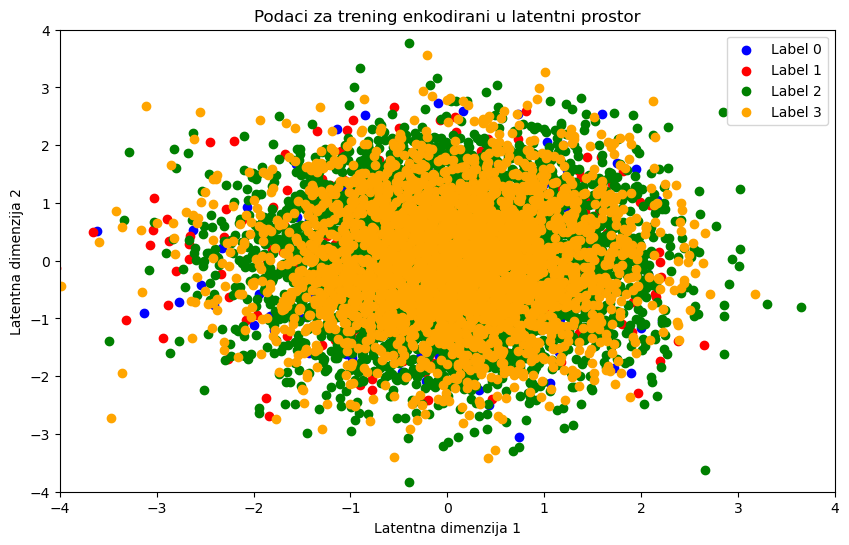

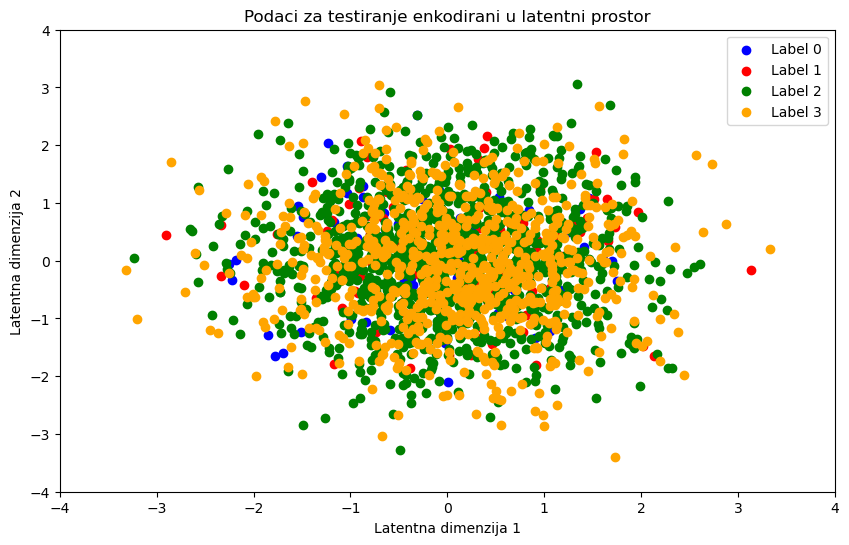

In [24]:
def plot_input_data(x_data, y_data):
    z_input = x_data
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plt.title("Podaci za trening enkodirani u latentni prostor")
plot_input_data(z_input, y_train)

plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(z_test_input, y_test)

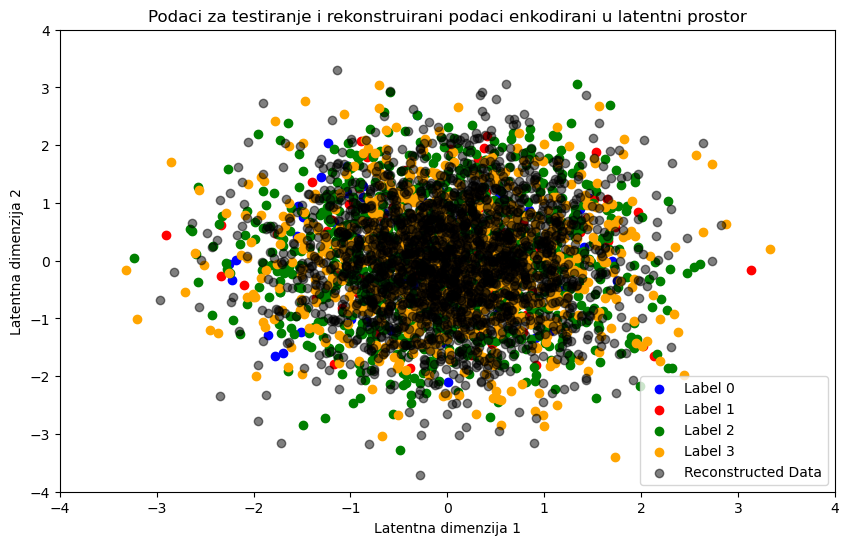

In [25]:
def plot_input_and_reconstructed_data(x_input_data, x_reconstructed, y_input_data):
    z_input = x_input_data
    recon_data_lsp = x_reconstructed
    
    unique_labels = np.unique(y_input_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_input_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.scatter(recon_data_lsp[:, 0], recon_data_lsp[:, 1], c='black', alpha=0.5, label='Reconstructed Data')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title("Podaci za testiranje i rekonstruirani podaci enkodirani u latentni prostor")
    plt.legend()
    plt.show()

plt.figure(figsize=(10, 6))
plot_input_and_reconstructed_data(z_test_input, reconstructed_z_test_encoded, y_test)


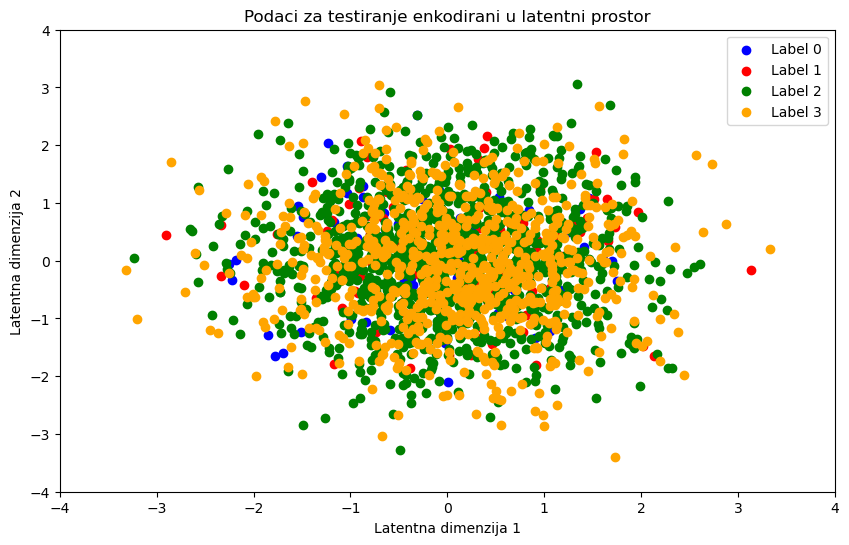

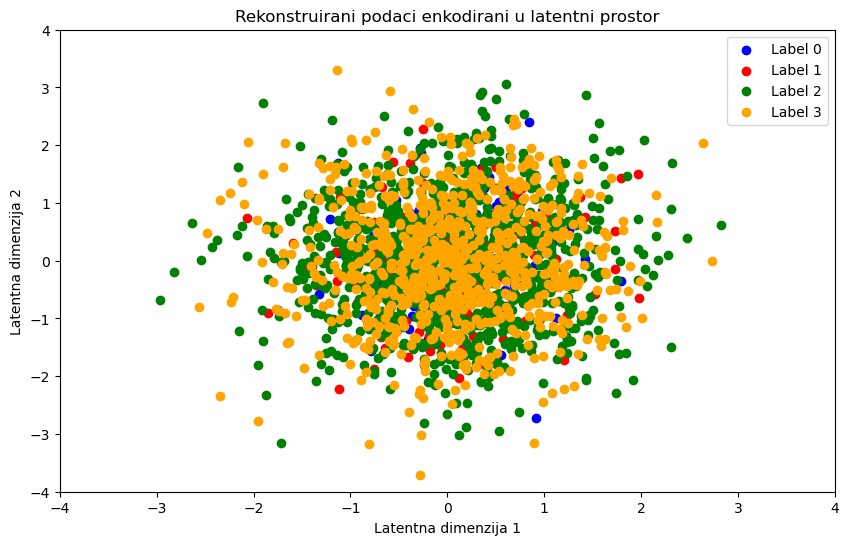

In [26]:
def plot_reconstructed_data(x_reconstructed, y_data):
    recon_data_lsp = x_reconstructed
    
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(recon_data_lsp[indices, 0], recon_data_lsp[indices, 1], 
                    c=label_colors[label], label=f'Label {label}')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(z_test_input, y_test)

plt.figure(figsize=(10, 6))
plt.title("Rekonstruirani podaci enkodirani u latentni prostor")
plot_reconstructed_data(reconstructed_z_test_encoded, y_test)

1/1 [==============================] - 0s 16ms/step


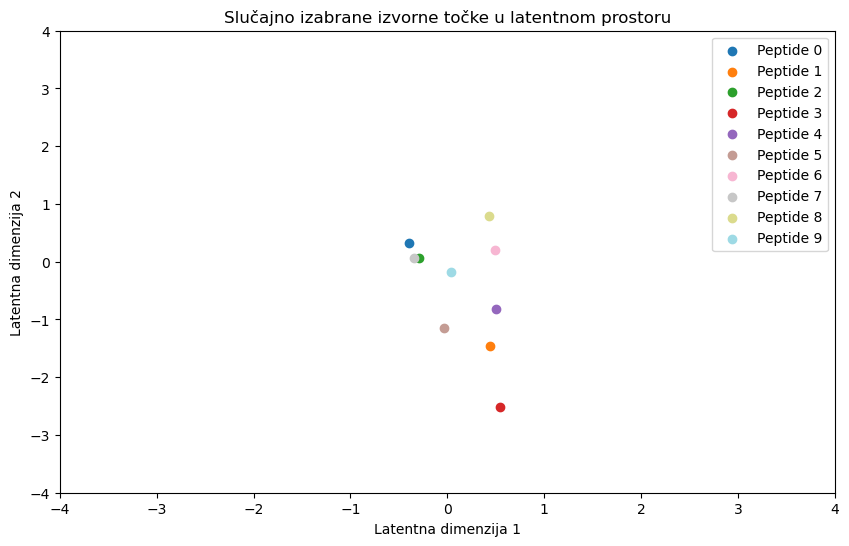

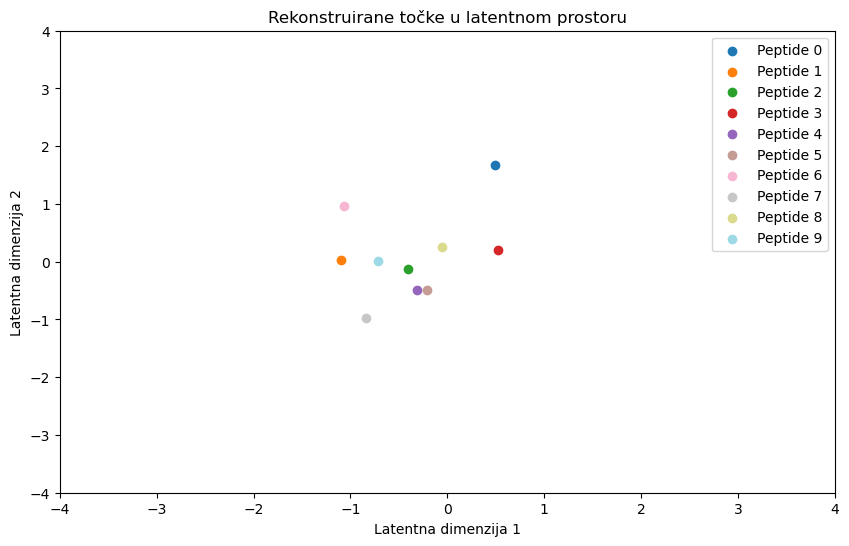

Relativna udaljenost između svake pojedine točke i njoj pripadajuće rekonstruirane točke: 
 [1.6071962, 2.1425421, 0.22638828, 2.713253, 0.87957793, 0.68481845, 1.7365279, 1.1534604, 0.7202057, 0.77664727] 

Prosječna relativna udaljenost između izvornih i rekonstruiranih točaka:  1.264061737060547


In [27]:
selected_indices = np.random.choice(len(x_test), 10, replace=False)

selected_peptides = x_test[selected_indices]

_, _, encoded_selected_peptides = vae.encoder.predict(selected_peptides)
reconstructed_peptides = vae.decoder.predict(encoded_selected_peptides)
_, _, encoded_reconstructed_peptides = vae.encoder.predict(reconstructed_peptides)


def plot_selected_data(x_data):
    z_input = x_data
    num_peptides = z_input.shape[0]
    unique_colors = plt.cm.tab20(np.linspace(0, 1, num_peptides))

    for i in range(num_peptides):
        plt.scatter(z_input[i, 0], z_input[i, 1], color=unique_colors[i], label=f'Peptide {i}')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()

    
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y)**2))


plt.figure(figsize=(10, 6))
plt.title("Slučajno izabrane izvorne točke u latentnom prostoru")
plot_selected_data(encoded_selected_peptides)

plt.figure(figsize=(10, 6))
plt.title("Rekonstruirane točke u latentnom prostoru")
plot_selected_data(encoded_reconstructed_peptides)


distances = []

for i in range(10):
    dist = euclidean_distance(encoded_selected_peptides[i], encoded_reconstructed_peptides[i])
        
    distances.append(dist)

print("Relativna udaljenost između svake pojedine točke i njoj pripadajuće rekonstruirane točke: \n", distances, "\n")
print("Prosječna relativna udaljenost između izvornih i rekonstruiranih točaka: ", np.sum(distances)/10)

In [28]:
#NORMALIZIRANA UDALJENOST U LATENTNOM PROSTORU

min_values = np.min(z_test_input, axis=0)
max_values = np.max(z_test_input, axis=0)

# Calculate the diagonal length of the latent space
latent_space_size = np.linalg.norm(max_values - min_values)
#print(min_values, max_values)
print(latent_space_size)

distances_test = []

for i in range(len(x_test)):
    dist = euclidean_distance(z_test_input[i], reconstructed_z_test_encoded[i])
        
    distances_test.append(dist)

print("Normalizirana prosječna udaljenost između izvornih i rekonstruiranih točaka: ", 
      np.sum(distances_test)/latent_space_size/len(x_test))

9.273623
Normalizirana prosječna udaljenost između izvornih i rekonstruiranih točaka:  0.16689818402321344


In [29]:
#PEARSON
from scipy.stats import spearmanr, kendalltau, pearsonr

#print(x_test)
#print(reconstructed_z_test_input)

print(pearsonr(x_test.flatten(), reconstructed_z_test_input.flatten()))

PearsonRResult(statistic=0.7395408150235275, pvalue=0.0)


In [30]:
#RAZLIKA I RMSE

difference = x_test - reconstructed_z_test_input
print(np.abs(np.mean(difference)))

mse = np.mean(np.square(x_test - reconstructed_z_test_input))
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")


0.0011690388959667128
RMSE: 0.09575255873271966


In [31]:
from Bio import pairwise2
from Bio.Seq import Seq

def calculate_sequence_similarity(seq1, seq2):
  
    seq1 = Seq(seq1)
    seq2 = Seq(seq2)

    alignments = pairwise2.align.globalxx(seq1, seq2)

    best_alignment = alignments[0]
    seq1_aligned, seq2_aligned, score, begin, end = best_alignment

    similarity = (score / max(len(seq1), len(seq2)))

    return similarity

similarities_train = []
similarities_test = []

for i in range(50):
    row_similarities_train = []
    row_similarities_test = []
    for j in range(50,101):
        sim_train = calculate_sequence_similarity(x_train_seq[i], x_train_seq[j])
        sim_test = calculate_sequence_similarity(x_test_seq[i], x_test_seq[j])
        row_similarities_train.append(sim_train)
        row_similarities_test.append(sim_test)
        
    similarities_train.append(row_similarities_train)
    similarities_test.append(row_similarities_test)
    
similarities_train = np.array(similarities_train)
similarities_test = np.array(similarities_test)

print(similarities_train)
print(similarities_test)

[[0.25581395 0.13953488 0.39534884 ... 0.39534884 0.18604651 0.34883721]
 [0.1025641  0.         0.12820513 ... 0.13157895 0.125      0.05263158]
 [0.20512821 0.28       0.23076923 ... 0.18421053 0.32       0.23684211]
 ...
 [0.33333333 0.21621622 0.35897436 ... 0.34210526 0.32432432 0.34210526]
 [0.33333333 0.17777778 0.26666667 ... 0.33333333 0.22222222 0.33333333]
 [0.07692308 0.25       0.15384615 ... 0.18421053 0.16666667 0.23684211]]
[[0.27272727 0.18604651 0.27906977 ... 0.27906977 0.20930233 0.30232558]
 [0.36363636 0.25581395 0.27906977 ... 0.3255814  0.1627907  0.18604651]
 [0.25       0.17241379 0.26666667 ... 0.14285714 0.3        0.2       ]
 ...
 [0.15909091 0.31034483 0.33333333 ... 0.26190476 0.28571429 0.14285714]
 [0.34090909 0.2972973  0.54054054 ... 0.28571429 0.24324324 0.2972973 ]
 [0.09090909 0.13793103 0.06666667 ... 0.0952381  0.17647059 0.2       ]]


In [32]:
distances_train = []
distances_test = []

for i in range(50):
    row_distances_train = []
    row_distances_test = []
    for j in range(50,101):
        dist_train = euclidean_distance(z_input[i], z_input[j])
        dist_test = euclidean_distance(z_test_input[i], z_test_input[j])
        row_distances_train.append(dist_train)
        row_distances_test.append(dist_test)
        
    distances_train.append(row_distances_train)
    distances_test.append(row_distances_test)
        
distances_train = np.array(distances_train)
distances_test = np.array(distances_test)

normalized_distances_train = scaler.fit_transform(distances_train)
normalized_distances_test = scaler.fit_transform(distances_test)

print(normalized_distances_train)
print(normalized_distances_test)

[[0.2845357  0.47581518 0.39751917 ... 0.10450916 0.28025776 0.29985103]
 [0.7869718  0.87326306 0.8122525  ... 0.65034044 0.76925606 0.79543364]
 [0.18582681 0.37549192 0.16236484 ... 0.15945488 0.         0.35801876]
 ...
 [0.22644717 0.26138842 0.39888346 ... 0.43198267 0.32901853 0.06501739]
 [0.13341743 0.3560619  0.2164122  ... 0.12109366 0.06599793 0.26547214]
 [0.24119267 0.3332402  0.4126377  ... 0.35759592 0.32823017 0.11529852]]
[[0.23511232 0.3483132  0.33011106 ... 0.15959808 0.40184674 0.48515067]
 [0.         0.         0.28851447 ... 0.3998764  0.04236018 0.3312692 ]
 [0.19880317 0.21884623 0.43425536 ... 0.5220477  0.23886403 0.32181853]
 ...
 [0.0426975  0.2080409  0.43681082 ... 0.30954155 0.27138132 0.11275177]
 [0.10845412 0.30886358 0.47959116 ... 0.19373435 0.37805986 0.09071163]
 [0.22400056 0.17280719 0.36235064 ... 0.5682001  0.1656673  0.43176347]]


In [33]:
correlation_train, p_value_train = spearmanr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = spearmanr(similarities_test.flatten(), distances_test.flatten())

print("Spearmanov koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test, "\n")

correlation_train, p_value_train = pearsonr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = pearsonr(similarities_test.flatten(), distances_test.flatten())

print("Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test, "\n")

correlation_train, p_value_train = kendalltau(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = kendalltau(similarities_test.flatten(), distances_test.flatten())

print("Kendall tau koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test)

Spearmanov koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.09751428896132905 0.011384470399462982
p-value: 8.073706671658448e-07 0.5655453978891246 

Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.12370625105721499 0.001007368644342626
p-value: 3.659848342219722e-10 0.959449276110159 

Kendall tau koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.06577766739828717 0.00785474563057655
p-value: 7.066653835355386e-07 0.5540055442190701
